In [2]:
# Initialize Libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# For reproducibility
np.random.seed(42)
random.seed(42)


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate a sequence of dates for 2021
dates = pd.date_range(start="2021-01-01", end="2021-12-31", freq='D')
df = pd.DataFrame({'dates': dates})

# Extract date elements (similar to lubridate functions)
df['weekday_str'] = df['dates'].dt.day_name()   # full weekday name
df['month_str'] = df['dates'].dt.month_name()   # full month name
df['day'] = df['dates'].dt.day                  # day of the month
df['year'] = df['dates'].dt.year                # year
df['weekday'] = df['dates'].dt.weekday + 1      # weekday as integer (Monday=1 to Sunday=7)
df['weeknum'] = df['dates'].dt.isocalendar().week # ISO week number
df['monthnum'] = df['dates'].dt.month           # month as integer

# Drop weekends (weekday 7 = Sunday, weekday 1 = Saturday in R; here 1 = Monday to 7 = Sunday in Python)
df = df[~df['weekday'].isin([7, 1])].reset_index(drop=True)


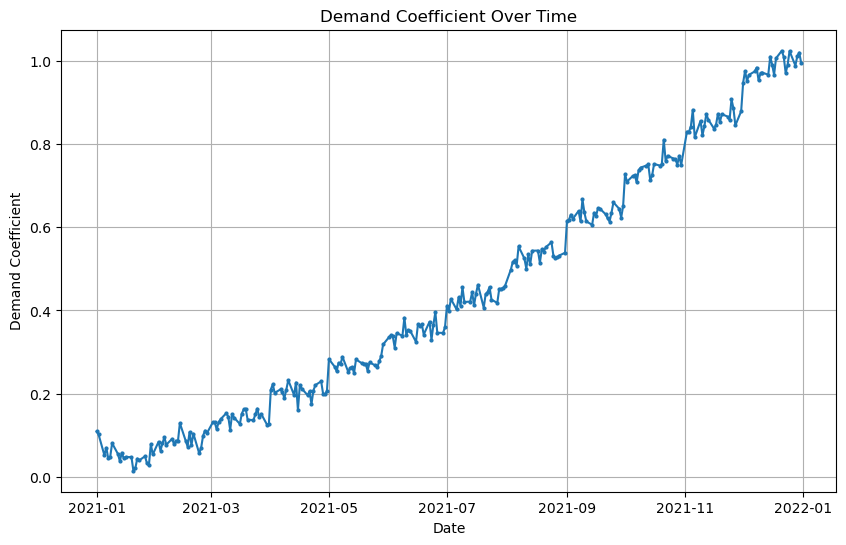

In [4]:
import matplotlib.pyplot as plt

# Calculate coefficients to modify call center "busy-ness"
df['month_coef'] = df['monthnum'] / 10
df['weeknum_coef'] = df['weeknum'] / 35
df['weekday_coef'] = df['weekday'] / 100
df['total_coef'] = df['month_coef'] * (1 + df['weeknum_coef']) + df['weekday_coef']

# Add stochasticity (jitter) to the coefficients
df['total_coef'] = df['total_coef'].apply(lambda x: (x + np.random.normal(0, 0.05)) / 3)

# Visualize the demand coefficient
plt.figure(figsize=(10, 6))
plt.plot(df['dates'], df['total_coef'], marker='o', linestyle='-', markersize=2)
plt.xlabel('Date')
plt.ylabel('Demand Coefficient')
plt.title('Demand Coefficient Over Time')
plt.grid(True)
plt.show()


In [5]:
pip install simpy

  Obtaining dependency information for simpy from https://files.pythonhosted.org/packages/48/72/920ed1224c94a8a5a69e6c1275ac7fe4eb911ba8feffddf469f1629d47f3/simpy-4.1.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import simpy
import random

# Queue Model parameters
agents = 4
base_arrival_rate = 13.7 / 60  # calls per minute
service_rate = 5  # average service time in minutes
simulation_time = 600  # each day runs for 600 minutes (10 hours)
max_calls = 500  # maximum number of calls per day

# Initialize a dataframe to store simulation results
df_calls = pd.DataFrame(columns=['date', 'start_time', 'end_time', 'activity_time', 'waiting_time'])

# Define the customer process
def customer(env, name, counter, service_rate, results, date):
    start_time = env.now
    with counter.request() as request:
        yield request  # wait for an available agent
        wait_time = env.now - start_time
        service_time = np.random.exponential(service_rate)
        yield env.timeout(service_time)
        end_time = env.now
        results.append({
            'date': date,
            'start_time': start_time,
            'end_time': end_time,
            'activity_time': service_time,
            'waiting_time': wait_time
        })

# Loop through each date and simulate calls
for idx, row in df.iterrows():
    day_arrival_rate = base_arrival_rate * (1 + row['total_coef'])
    date = row['dates']
    
    # Initialize SimPy environment and resource
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=agents)
    
    # Generate customers based on arrival rate
    results = []
    def customer_arrivals(env, counter, service_rate, results):
        for i in range(max_calls):
            yield env.timeout(random.expovariate(day_arrival_rate))
            env.process(customer(env, f'Customer_{i}', counter, service_rate, results, date))

    env.process(customer_arrivals(env, counter, service_rate, results))
    env.run(until=simulation_time)
    
    # Append results for each day
    df_day = pd.DataFrame(results)
    df_calls = pd.concat([df_calls, df_day], ignore_index=True)

# View the simulated data
df_calls.head()


,date,start_time,end_time,activity_time,waiting_time
0,2021-01-01,5.399678,6.350652,0.950974,0.0
1,2021-01-01,4.129269,7.336521,3.207252,0.0
2,2021-01-01,4.029220,7.411810,3.382590,0.0
3,2021-01-01,6.397389,9.241885,2.844496,0.0
4,2021-01-01,11.665057,14.206740,2.541683,0.0


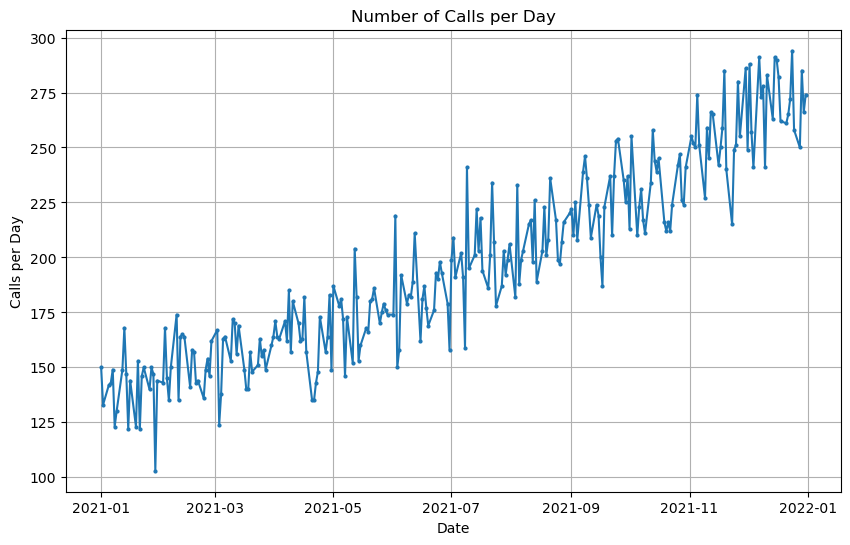

In [6]:
import matplotlib.pyplot as plt

# Ensure 'date' column is in datetime format
df_calls['date'] = pd.to_datetime(df_calls['date'], format='%Y-%m-%d')

# Group by date and count calls per day
calls_per_day = df_calls.groupby('date').size().reset_index(name='calls_per_day')

# Plot the calls per day
plt.figure(figsize=(10, 6))
plt.plot(calls_per_day['date'], calls_per_day['calls_per_day'], marker='o', linestyle='-', markersize=2)
plt.xlabel('Date')
plt.ylabel('Calls per Day')
plt.title('Number of Calls per Day')
plt.grid(True)
plt.show()


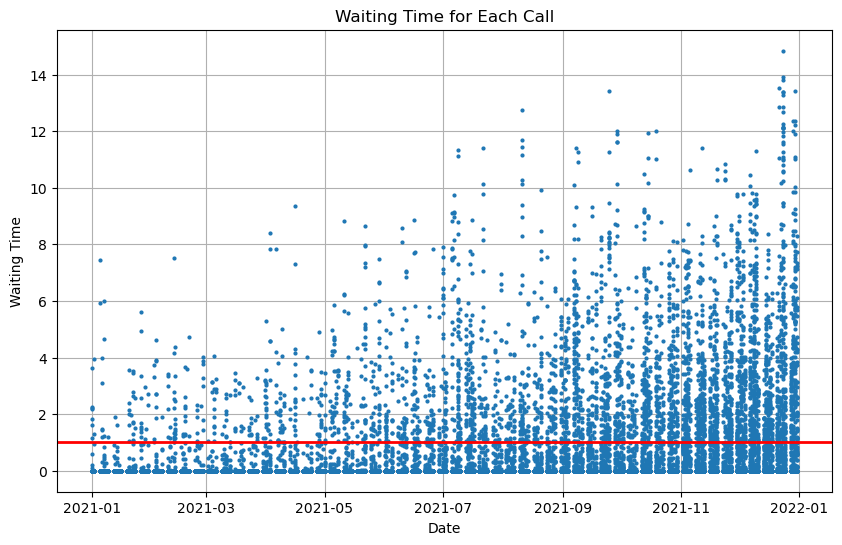

In [7]:
# Plot the waiting time for each call
plt.figure(figsize=(10, 6))
plt.plot(df_calls['date'], df_calls['waiting_time'], marker='o', linestyle='', markersize=2)
plt.axhline(y=1, color='red', linewidth=2)  # Add a reference line at y=1
plt.xlabel('Date')
plt.ylabel('Waiting Time')
plt.title('Waiting Time for Each Call')
plt.grid(True)
plt.show()


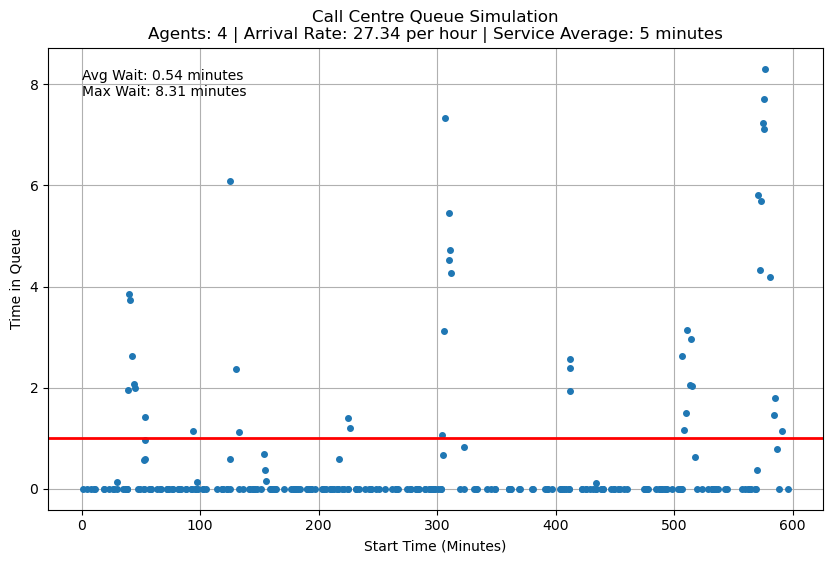

In [8]:
# Get data for the last day in the dataset
last_day = df_calls['date'].max()
df_last_day = df_calls[df_calls['date'] == last_day]

# Plot waiting time for each call on the last day
plt.figure(figsize=(10, 6))
plt.plot(df_last_day['start_time'], df_last_day['waiting_time'], marker='o', linestyle='', markersize=4)
plt.axhline(y=1, color='red', linewidth=2)  # Reference line at 1 minute

# Annotate with average and maximum wait time
avg_wait = df_last_day['waiting_time'].mean()
max_wait = df_last_day['waiting_time'].max()
plt.text(0, max_wait, f"Avg Wait: {round(avg_wait, 2)} minutes\nMax Wait: {round(max_wait, 2)} minutes",
         verticalalignment='top', fontsize=10)

# Labels and title
plt.xlabel("Start Time (Minutes)")
plt.ylabel("Time in Queue")
plt.title(f"Call Centre Queue Simulation\nAgents: {agents} | Arrival Rate: {round(day_arrival_rate * 60, 2)} per hour | Service Average: {service_rate} minutes")
plt.grid(True)
plt.show()
